In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU

In [2]:
Autoencoder = tf.keras.models.load_model('k_fold_best_model_test4', compile=False)

In [3]:
phis=[0.93,1.0,1.10] 
Ts=[1160,1200,1130]

name_11='State_space_cte_pressure_T' 
name_12='_phi_'
name_21='Reaction_rates_cte_pressure_T'
name_22='_phi_'

end='.csv'

In [4]:
def hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:12]
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    n_columns_source=np.shape(cantera_sources)[1]
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[0,1:]
    maximum_values=maximum_values.to_numpy()
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [5]:
k=1
cantera_species=pd.read_csv(name_11+str(Ts[k])+name_12+str(phis[k])+end)
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(name_21+str(Ts[k])+name_22+str(phis[k])+end)
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
maximum_values=pd.DataFrame(maximum_values)

In [6]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)

In [7]:
results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()

In [8]:
interest_vector=['H2O','O2','H2','T[K]','OH','HO2','H2O2']

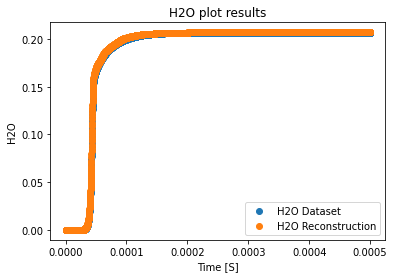

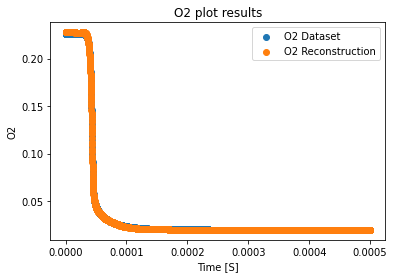

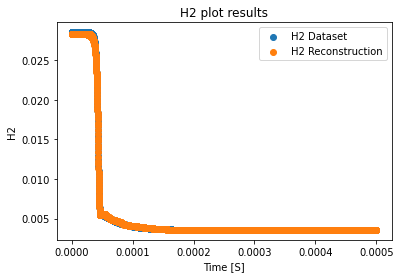

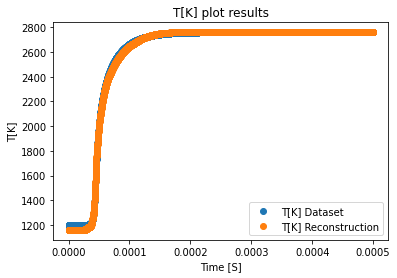

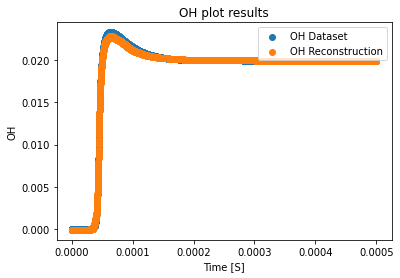

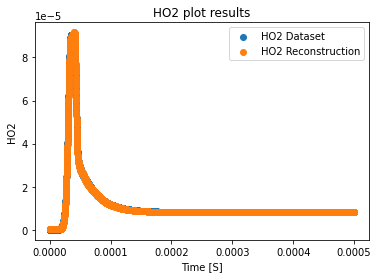

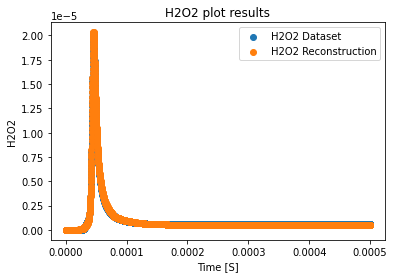

In [9]:
t_index=columns.index('t[s]shift')
t_trans=maximum_values.columns.get_loc('t[s]')
time_plot=(dataset.iloc[:,t_index])*maximum_values.iloc[0,t_trans]
    
for k in range(len(interest_vector)):
    original_index=columns.index(interest_vector[k]+'shift')
    #print(columns[original_index])
    results_index=columns.index(interest_vector[k]) #minues one due to the time column presence 
    #print(columns[results_index])
    #print(results_index-1)
    transformation_index=maximum_values.columns.get_loc(interest_vector[k])
    plot_name=interest_vector[k]+'.png'
    
    input_label=interest_vector[k]+' Dataset'
    output_label=interest_vector[k]+' Reconstruction'
    
    original=(dataset.iloc[:,original_index]).to_numpy()
    #original=original*transformation_values[1,original_index]
    #original=original+transformation_values[0,original_index]
    #original=np.exp(original)-1
    original=original*maximum_values.iloc[0,transformation_index]
    
    output=(results[:,results_index-1])
    #output=output*transformation_values[1,results_index]
    #output=output+transformation_values[0,results_index]
    #output=np.exp(output)-1
    output=output*maximum_values.iloc[0,transformation_index]
    
    plt.figure(k)
    plt.scatter(time_plot,original, label=input_label)
    plt.scatter(time_plot,output, label=output_label)
    plt.title(interest_vector[k]+' plot results')
    plt.xlabel('Time [S]')
    plt.ylabel(interest_vector[k])
    plt.legend()

In [10]:
latent_space=Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy())).numpy()

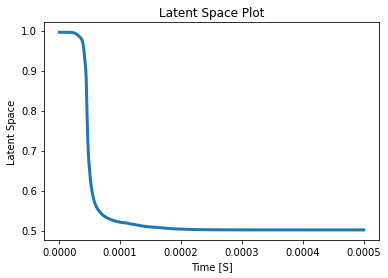

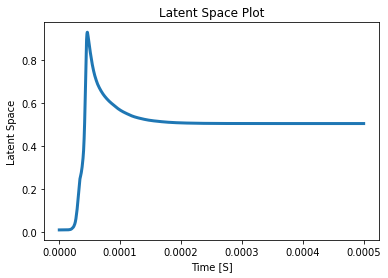

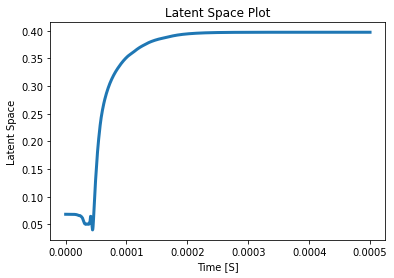

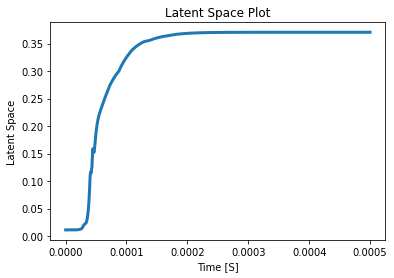

In [11]:
reduced_size=4

if reduced_size==1:
    plt.figure()
    plt.plot(time_plot,latent_space,linewidth=3)
    plt.title('Latent Space Plot')
    plt.xlabel('Time [S]')
    plt.ylabel('Latent Space')
else: 
    for i in range(reduced_size):
            plt.figure(i)
            plt.plot(time_plot,latent_space[:,i],linewidth=3)
            plt.title('Latent Space Plot')
            plt.xlabel('Time [S]')
            plt.ylabel('Latent Space')

In [12]:
corr_dataset=dataset.iloc[:,1:2+n_columns_mass_fraction+n_columns_source]
corr_columns=corr_dataset.columns.to_list()
corr_dataset

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,0.430892,0.885458,1.150531e-09,0.997196,5.144054e-11,7.240271e-11,1.573112e-12,0.000002,3.624549e-10,-2.801616e-08,5.996225e-08,-6.379635e-08,7.524353e-09,7.317545e-09,3.395073e-10,1.337874e-04,3.436094e-08
1,0.430892,0.885458,2.286126e-09,0.997196,1.754366e-10,2.720046e-10,1.094616e-11,0.000004,1.451762e-09,-2.881323e-08,5.968010e-08,-6.585636e-08,1.193320e-08,1.332981e-08,1.157881e-09,1.344889e-04,6.887562e-08
2,0.430892,0.885458,3.423431e-09,0.997196,3.440388e-10,5.769386e-10,3.306626e-11,0.000005,3.271229e-09,-2.992742e-08,6.009707e-08,-6.791946e-08,1.483538e-08,1.835911e-08,2.270654e-09,1.351914e-04,1.035429e-07
3,0.430892,0.885458,4.573670e-09,0.997196,5.435719e-10,9.706971e-10,7.112930e-11,0.000007,5.824084e-09,-3.127617e-08,6.101010e-08,-7.000604e-08,1.697692e-08,2.263940e-08,3.587572e-09,1.359020e-04,1.383639e-07
4,0.430892,0.885458,5.745061e-09,0.997196,7.671048e-10,1.440724e-09,1.274551e-10,0.000009,9.113597e-09,-3.281374e-08,6.230310e-08,-7.213099e-08,1.870887e-08,2.634644e-08,5.062888e-09,1.366258e-04,1.733413e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.991159,0.110547,1.196932e-01,0.088078,8.474259e-01,2.147999e-01,9.297617e-01,0.073162,2.612068e-02,-1.669582e-09,-3.309385e-09,-1.685345e-09,-9.397404e-09,-5.369258e-09,3.748735e-09,-3.228181e-09,-9.060090e-10
4995,0.991159,0.110547,1.196932e-01,0.088078,8.474259e-01,2.147999e-01,9.297617e-01,0.073162,2.612068e-02,-1.663805e-09,-3.297928e-09,-1.679490e-09,-9.365483e-09,-5.350631e-09,3.735793e-09,-3.216914e-09,-9.027595e-10
4996,0.991159,0.110547,1.196932e-01,0.088078,8.474259e-01,2.147999e-01,9.297617e-01,0.073162,2.612068e-02,-1.658042e-09,-3.286523e-09,-1.673656e-09,-9.333627e-09,-5.332064e-09,3.722891e-09,-3.205865e-09,-8.997176e-10
4997,0.991159,0.110547,1.196932e-01,0.088078,8.474259e-01,2.147999e-01,9.297617e-01,0.073162,2.612068e-02,-1.652299e-09,-3.275163e-09,-1.667841e-09,-9.301507e-09,-5.313717e-09,3.710014e-09,-3.194832e-09,-8.964972e-10


In [13]:
iterations=np.shape(corr_dataset)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes=np.zeros(iterations) #rows, columns
    corr_indexes=np.array([corr_indexes])
    
    for j in range(iterations):
        corr_indexes[:,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space)
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)
else: 
    
    corr_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes[k,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space[:,k])
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)

In [14]:
corr_indexes

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,-0.997221,0.997518,0.695817,0.997518,0.615497,0.678503,-0.997518,0.800873,0.729455,-0.885357,-0.668111,-0.887880,-0.536760,-0.659461,0.872129,-0.716654,-0.664081
1,-0.677704,0.677406,0.978776,0.677406,0.938251,0.995861,-0.677406,0.873836,0.945175,-0.784098,-0.958545,-0.786925,-0.805183,-0.948107,0.802658,-0.957962,-0.953792
2,0.983416,-0.983119,-0.713355,-0.983119,-0.633148,-0.696066,0.983119,-0.817096,-0.746946,0.902432,0.655497,0.904996,0.523024,0.645640,-0.889246,0.714156,0.650704
3,0.998167,-0.998464,-0.697142,-0.998464,-0.617014,-0.679942,0.998464,-0.802051,-0.730785,0.886448,0.669555,0.888967,0.538359,0.660915,-0.873235,0.717944,0.665529


O2       0.997518
H2       0.997518
H2Ow     0.872129
HO2      0.800873
H2O2     0.729455
H        0.695817
O        0.678503
OH       0.615497
OHw     -0.536760
Ow      -0.659461
H2O2w   -0.664081
Hw      -0.668111
HO2w    -0.716654
H2w     -0.885357
O2w     -0.887880
T[K]    -0.997221
H2O     -0.997518
Name: 0, dtype: float64
O        0.995861
H        0.978776
H2O2     0.945175
OH       0.938251
HO2      0.873836
H2Ow     0.802658
O2       0.677406
H2       0.677406
H2O     -0.677406
T[K]    -0.677704
H2w     -0.784098
O2w     -0.786925
OHw     -0.805183
Ow      -0.948107
H2O2w   -0.953792
HO2w    -0.957962
Hw      -0.958545
Name: 1, dtype: float64
T[K]     0.983416
H2O      0.983119
O2w      0.904996
H2w      0.902432
HO2w     0.714156
Hw       0.655497
H2O2w    0.650704
Ow       0.645640
OHw      0.523024
OH      -0.633148
O       -0.696066
H       -0.713355
H2O2    -0.746946
HO2     -0.817096
H2Ow    -0.889246
H2      -0.983119
O2      -0.983119
Name: 2, dtype: float64
H2O      0

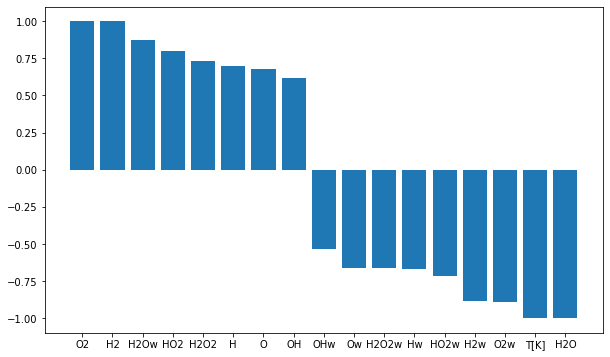

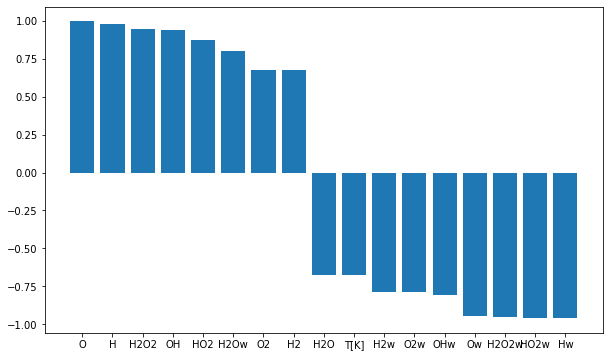

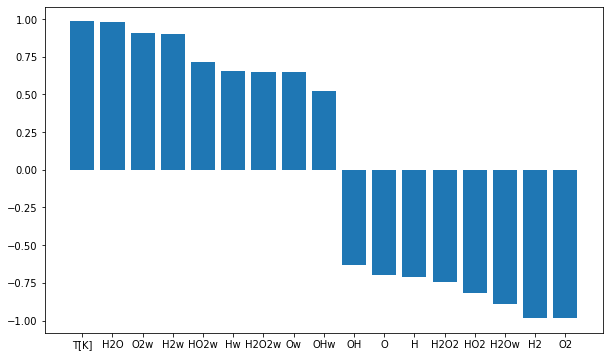

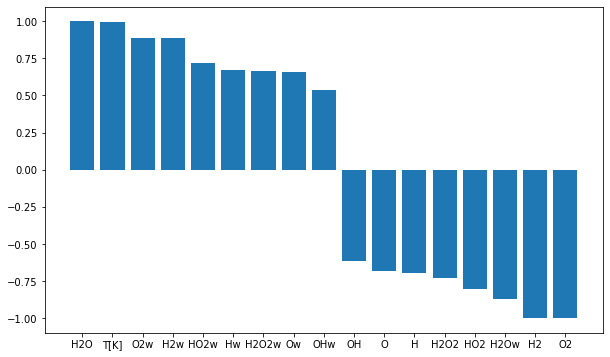

In [15]:
for m in range(reduced_size):
    
    indexes=corr_indexes.iloc[m,:].sort_values(ascending=False)
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [16]:
if reduced_size==1:
    spearman_indexes=np.zeros(iterations) #rows, columns
    spearman_indexes=np.array([spearman_indexes])
    
    for j in range(iterations):
        spearman_indexes[:,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space)
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)
else: 
    
    spearman_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            spearman_indexes[k,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space[:,k])
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)

In [17]:
spearman_indexes

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,-0.999884,0.999889,0.568926,0.999889,0.464267,0.544571,-0.999889,0.719007,0.621309,-0.910140,-0.507357,-0.913007,-0.329088,-0.494602,0.888556,-0.583253,-0.501462
1,-0.540682,0.540678,0.976712,0.540678,0.926823,0.997526,-0.540678,0.828187,0.934633,-0.750631,-0.961800,-0.753532,-0.748329,-0.946267,0.777639,-0.960011,-0.954615
2,0.998456,-0.998452,-0.580333,-0.998452,-0.465924,-0.553314,0.998452,-0.743605,-0.638762,0.925707,0.507558,0.928107,0.327172,0.493198,-0.905441,0.594936,0.500615
3,0.999961,-0.999966,-0.569039,-0.999966,-0.464390,-0.544694,0.999966,-0.719107,-0.621419,0.910224,0.507559,0.913091,0.329222,0.494794,-0.888644,0.583365,0.501685


O2       0.999889
H2       0.999889
H2Ow     0.888556
HO2      0.719007
H2O2     0.621309
H        0.568926
O        0.544571
OH       0.464267
OHw     -0.329088
Ow      -0.494602
H2O2w   -0.501462
Hw      -0.507357
HO2w    -0.583253
H2w     -0.910140
O2w     -0.913007
T[K]    -0.999884
H2O     -0.999889
Name: 0, dtype: float64
O        0.997526
H        0.976712
H2O2     0.934633
OH       0.926823
HO2      0.828187
H2Ow     0.777639
O2       0.540678
H2       0.540678
H2O     -0.540678
T[K]    -0.540682
OHw     -0.748329
H2w     -0.750631
O2w     -0.753532
Ow      -0.946267
H2O2w   -0.954615
HO2w    -0.960011
Hw      -0.961800
Name: 1, dtype: float64
T[K]     0.998456
H2O      0.998452
O2w      0.928107
H2w      0.925707
HO2w     0.594936
Hw       0.507558
H2O2w    0.500615
Ow       0.493198
OHw      0.327172
OH      -0.465924
O       -0.553314
H       -0.580333
H2O2    -0.638762
HO2     -0.743605
H2Ow    -0.905441
H2      -0.998452
O2      -0.998452
Name: 2, dtype: float64
H2O      0

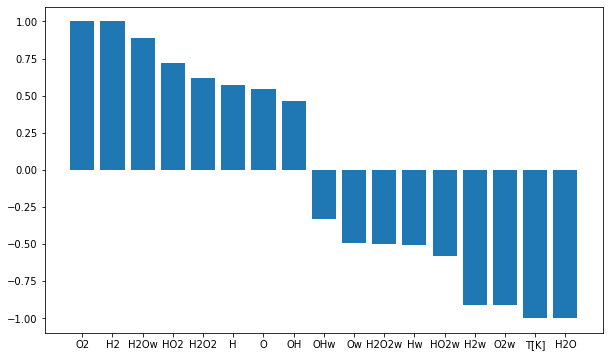

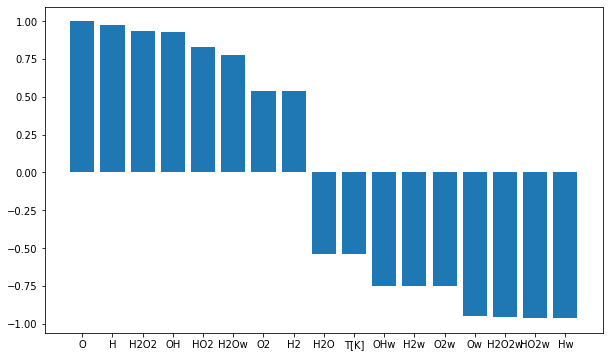

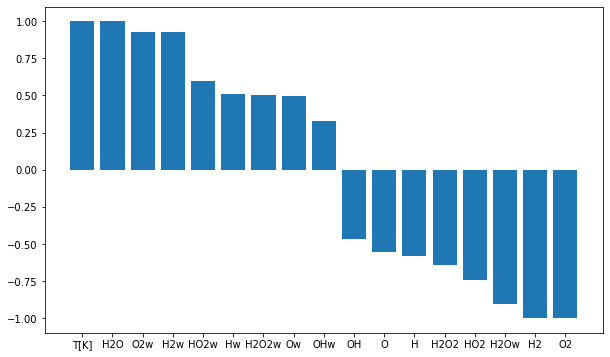

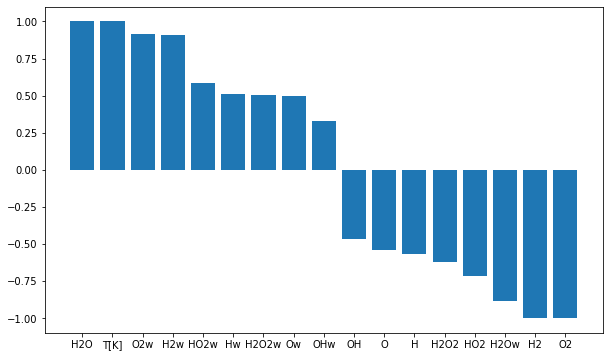

In [18]:
for m in range(reduced_size):
    
    indexes=spearman_indexes.iloc[m,:].sort_values(ascending=False)
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [19]:
n_samples=np.shape(latent_space)[0]

corr_dataset_=corr_dataset.iloc[1:,:]

latent_space_=latent_space[0:n_samples-1,:]

In [20]:
print(np.shape(corr_dataset_))
print(np.shape(latent_space_))

(4998, 17)
(4998, 4)


In [21]:
iterations=np.shape(corr_dataset_)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes_=np.zeros(iterations) #rows, columns
    corr_indexes_=np.array([corr_indexes_])
    
    for j in range(iterations):
        corr_indexes_[:,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_)
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)
else: 
    
    corr_indexes_=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes_[k,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_[:,k])
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)

In [22]:
corr_indexes_

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,-0.997233,0.997519,0.696500,0.997519,0.616147,0.679179,-0.997519,0.801598,0.730151,-0.885985,-0.668711,-0.888471,-0.537277,-0.660055,0.872882,-0.717285,-0.664678
1,-0.677639,0.677354,0.978041,0.677354,0.938969,0.995218,-0.677354,0.873059,0.944426,-0.783416,-0.959343,-0.786281,-0.805951,-0.948903,0.801853,-0.957278,-0.954590
2,0.983404,-0.983119,-0.714050,-0.983119,-0.633811,-0.696754,0.983119,-0.817815,-0.747654,0.903050,0.656241,0.905581,0.523552,0.646251,-0.889991,0.714894,0.651410
3,0.998179,-0.998464,-0.697818,-0.998464,-0.617663,-0.680613,0.998464,-0.802774,-0.731470,0.887074,0.670150,0.889557,0.538874,0.661507,-0.873986,0.718574,0.666124


O2       0.997519
H2       0.997519
H2Ow     0.872882
HO2      0.801598
H2O2     0.730151
H        0.696500
O        0.679179
OH       0.616147
OHw     -0.537277
Ow      -0.660055
H2O2w   -0.664678
Hw      -0.668711
HO2w    -0.717285
H2w     -0.885985
O2w     -0.888471
T[K]    -0.997233
H2O     -0.997519
Name: 0, dtype: float64
O        0.995218
H        0.978041
H2O2     0.944426
OH       0.938969
HO2      0.873059
H2Ow     0.801853
O2       0.677354
H2       0.677354
H2O     -0.677354
T[K]    -0.677639
H2w     -0.783416
O2w     -0.786281
OHw     -0.805951
Ow      -0.948903
H2O2w   -0.954590
HO2w    -0.957278
Hw      -0.959343
Name: 1, dtype: float64
T[K]     0.983404
H2O      0.983119
O2w      0.905581
H2w      0.903050
HO2w     0.714894
Hw       0.656241
H2O2w    0.651410
Ow       0.646251
OHw      0.523552
OH      -0.633811
O       -0.696754
H       -0.714050
H2O2    -0.747654
HO2     -0.817815
H2Ow    -0.889991
H2      -0.983119
O2      -0.983119
Name: 2, dtype: float64
H2O      0

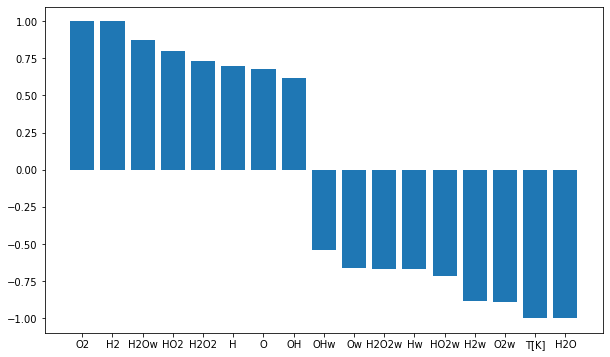

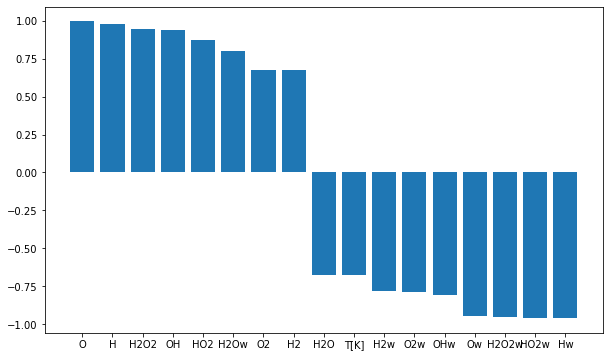

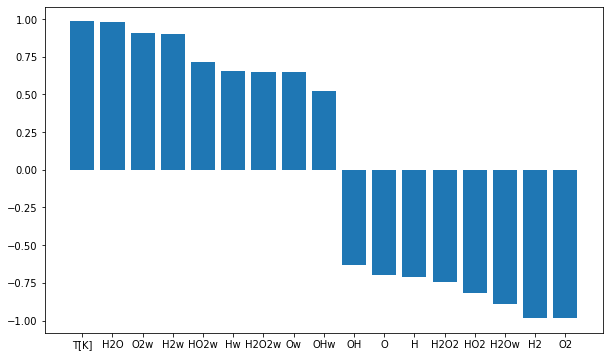

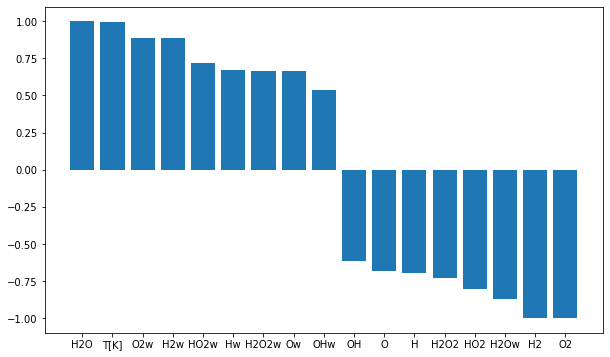

In [23]:
for m in range(reduced_size):
    
    indexes=corr_indexes_.iloc[m,:].sort_values(ascending=False)
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)